In [56]:
!pip install ta --quiet

In [57]:
# Imports

# Essential
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import joblib

# Sci-kit and Tensorflow
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# from sklearn.preprocessing import MinMaxScaler
# import requests

# Time range: past year
end_date = datetime.now()
start_date = end_date - timedelta(days=3650)

# Download data and include adjusted close
amzn_data = yf.download("AMZN", start=start_date, end=end_date, auto_adjust=False)

# Check available columns
# print("Columns:", amzn_data.columns)


# Get PE ratio from metadata
amzn = yf.Ticker("AMZN")
pe_ratio = amzn.info.get('trailingPE', None)

# If PE ratio is not available, set it to NaN
if pe_ratio is None:
    pe_ratio = float('nan')  # Set it to NaN for proper DataFrame handling
else:
    pe_ratio = float(pe_ratio)  # Ensure it's a float

# Create a Series for the PE ratio with the same date index as amzn_data
pe_series = pd.Series(pe_ratio, index=amzn_data.index)

# Combine the PE ratio Series with the historical data
amzn_data['PE_Ratio'] = pe_series

# Daily Volatility (using 7-day rolling standard deviation of log returns)
amzn_data['Log_Return'] = (amzn_data['Adj Close'] / amzn_data['Adj Close'].shift(1)).apply(np.log)
amzn_data['Volatility_7d'] = amzn_data['Log_Return'].rolling(window=7).std()

# Simulated sentiment based on daily percent change
if 'Adj Close' in amzn_data.columns:
    #MA past week
    amzn_data['MA_7'] = amzn_data['Adj Close'].rolling(window=7).mean()
    #MA past month
    amzn_data['MA_30'] = amzn_data['Adj Close'].rolling(window=30).mean()
    #MA past year
    amzn_data['MA_365'] = amzn_data['Adj Close'].rolling(window=365).mean()

    amzn_data['Pct_Change'] = amzn_data['Adj Close'].pct_change()
    # amzn_data['Sentiment'] = amzn_data['Pct_Change'].apply(
    #     lambda x: 'Bullish' if x > 0 else ('Bearish' if x < 0 else 'Neutral')
    # )
else:
    print("⚠️ 'Adj Close' not found in the data. Cannot compute moving averages or sentiment.")

# # Replace with your Finnhub API key
# api_key = "d07ap6hr01qrslhn6ssgd07ap6hr01qrslhn6st0"
# # Ticker symbol for Amazon
# ticker = "AMZN"

# # Finnhub API endpoint for sentiment analysis
# url = f"https://finnhub.io/api/v1/news-sentiment?symbol={ticker}&token={api_key}"

# # Make the API request
# response = requests.get(url)

# sentiment_data = None
# # Check if the request was successful
# if response.status_code == 200:
#     sentiment_data = response.json()
#     print("Sentiment Data:", sentiment_data)
#     sentiment_score = sentiment_data["sentiment"]
#     amzn_data['Sentiment_score'] = sentiment_score
# else:
#     print("Failed to fetch sentiment data. Status code:", response.status_code)
#     amzn_data['Sentiment_score'] = float('nan')  # Set sentiment score to NaN if API fails


# Check available columns after adding metrics
# Now, modify the second index
new_columns = []

for col in amzn_data.columns:
    # Create a new tuple with the existing first index and 'AMZN' as the second index
    new_columns.append((col[0], 'AMZN'))

# Update the DataFrame's columns
amzn_data.columns = pd.MultiIndex.from_tuples(new_columns)

print("Columns:", amzn_data.columns)

# Display last few rows
print(len(amzn_data))
print(amzn_data.head())
print(amzn_data.tail())

[*********************100%***********************]  1 of 1 completed


Columns: MultiIndex([(    'Adj Close', 'AMZN'),
            (        'Close', 'AMZN'),
            (         'High', 'AMZN'),
            (          'Low', 'AMZN'),
            (         'Open', 'AMZN'),
            (       'Volume', 'AMZN'),
            (     'PE_Ratio', 'AMZN'),
            (   'Log_Return', 'AMZN'),
            ('Volatility_7d', 'AMZN'),
            (         'MA_7', 'AMZN'),
            (        'MA_30', 'AMZN'),
            (       'MA_365', 'AMZN'),
            (   'Pct_Change', 'AMZN')],
           )
2513
           Adj Close    Close       High        Low       Open    Volume  \
                AMZN     AMZN       AMZN       AMZN       AMZN      AMZN   
Date                                                                       
2015-05-04   21.1520  21.1520  21.488501  21.121000  21.240000  45408000   
2015-05-05   21.0595  21.0595  21.375500  21.051001  21.142500  57128000   
2015-05-06   20.9550  20.9550  21.136000  20.727501  21.071501  51050000   
2015-05-0

In [58]:
amzn_data.describe()
# print(len(amzn_data))

,Adj Close,Close,High,Low,Open,Volume,PE_Ratio,Log_Return,Volatility_7d,MA_7,MA_30,MA_365,Pct_Change
,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN
count,2513.000000,2513.000000,2513.000000,2513.000000,2513.000000,2.513000e+03,2.513000e+03,2512.000000,2506.000000,2507.000000,2484.000000,2149.000000,2512.000000
mean,107.376059,107.376059,108.637993,106.044109,107.398888,7.516686e+07,3.388607e+01,0.000868,0.017871,107.384716,107.438367,106.570960,0.001082
std,55.222817,55.222817,55.897495,54.526332,55.244289,3.951698e+07,8.954620e-13,0.020643,0.010533,55.078341,54.594027,44.122860,0.020678
min,20.955000,20.955000,21.136000,20.727501,21.030001,1.500750e+07,3.388607e+01,-0.151398,0.001943,21.296714,21.397033,30.563562,-0.140494
25%,54.710999,54.710999,55.097000,52.527500,53.477501,4.975600e+07,3.388607e+01,-0.008853,0.010569,53.783321,54.820541,71.124137,-0.008814
50%,97.527496,97.527496,98.489998,96.099998,97.389999,6.462250e+07,3.388607e+01,0.001125,0.015381,97.280000,97.307483,115.413045,0.001126
75%,158.100494,158.100494,159.910507,156.149994,158.300507,8.930800e+07,3.388607e+01,0.011506,0.022269,157.894928,158.412236,145.920290,0.011572
max,242.059998,242.059998,242.520004,238.029999,239.020004,4.381880e+08,3.388607e+01,0.126949,0.067685,237.695714,230.223333,186.450329,0.135359


In [59]:
amzn_data.info()
# print(len(amzn_data))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2513 entries, 2015-05-04 to 2025-04-29
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   (Adj Close, AMZN)      2513 non-null   float64
 1   (Close, AMZN)          2513 non-null   float64
 2   (High, AMZN)           2513 non-null   float64
 3   (Low, AMZN)            2513 non-null   float64
 4   (Open, AMZN)           2513 non-null   float64
 5   (Volume, AMZN)         2513 non-null   int64  
 6   (PE_Ratio, AMZN)       2513 non-null   float64
 7   (Log_Return, AMZN)     2512 non-null   float64
 8   (Volatility_7d, AMZN)  2506 non-null   float64
 9   (MA_7, AMZN)           2507 non-null   float64
 10  (MA_30, AMZN)          2484 non-null   float64
 11  (MA_365, AMZN)         2149 non-null   float64
 12  (Pct_Change, AMZN)     2512 non-null   float64
dtypes: float64(12), int64(1)
memory usage: 274.9 KB


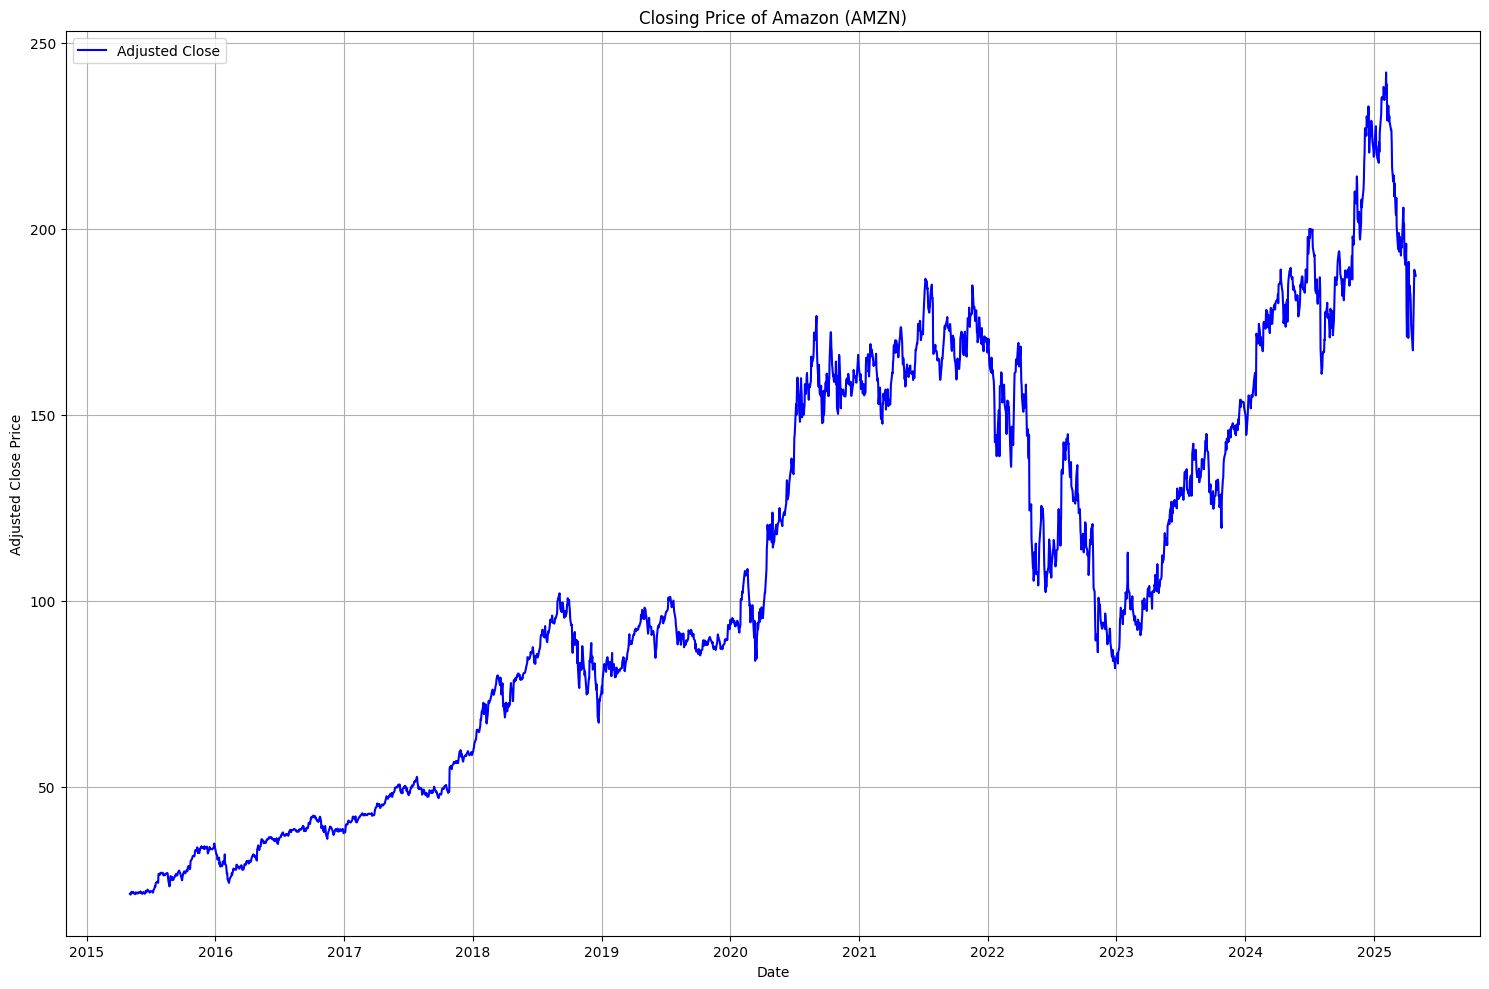

In [60]:

# Time range: past 3 years
# end_date = datetime.now()
# start_date = end_date - timedelta(days=1095)

# Download data for AMZN
# amzn_data = yf.download("AMZN", start=start_date, end=end_date, auto_adjust=False)

# Let's see a historical view of the closing price
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

# Plotting the adjusted closing price
plt.plot(amzn_data['Adj Close'], label='Adjusted Close', color='blue')
plt.ylabel('Adjusted Close Price')
plt.xlabel('Date')
plt.title("Closing Price of Amazon (AMZN)")
plt.legend(loc='upper left')
plt.grid()

plt.tight_layout()
plt.show()


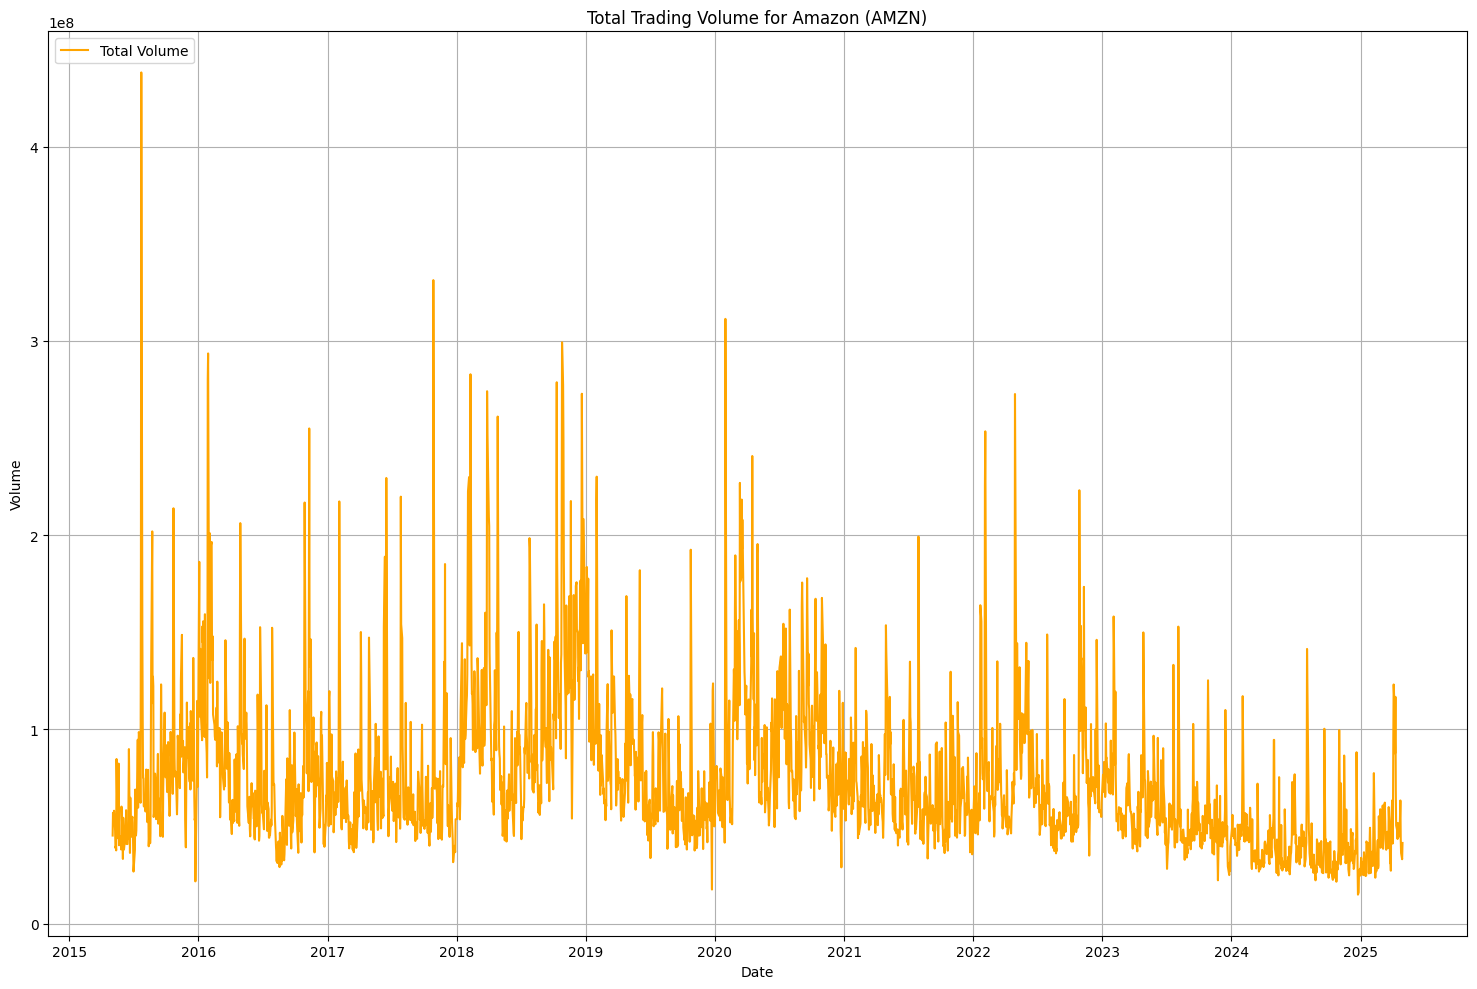

In [61]:
# Now let's plot the total volume of stock being traded each day for Amazon
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

# Plotting the trading volume for AMZN
plt.plot(amzn_data['Volume'], label='Total Volume', color='orange')
plt.ylabel('Volume')
plt.xlabel('Date')
plt.title("Total Trading Volume for Amazon (AMZN)")
plt.legend(loc='upper left')
plt.grid()

plt.tight_layout()
plt.show()

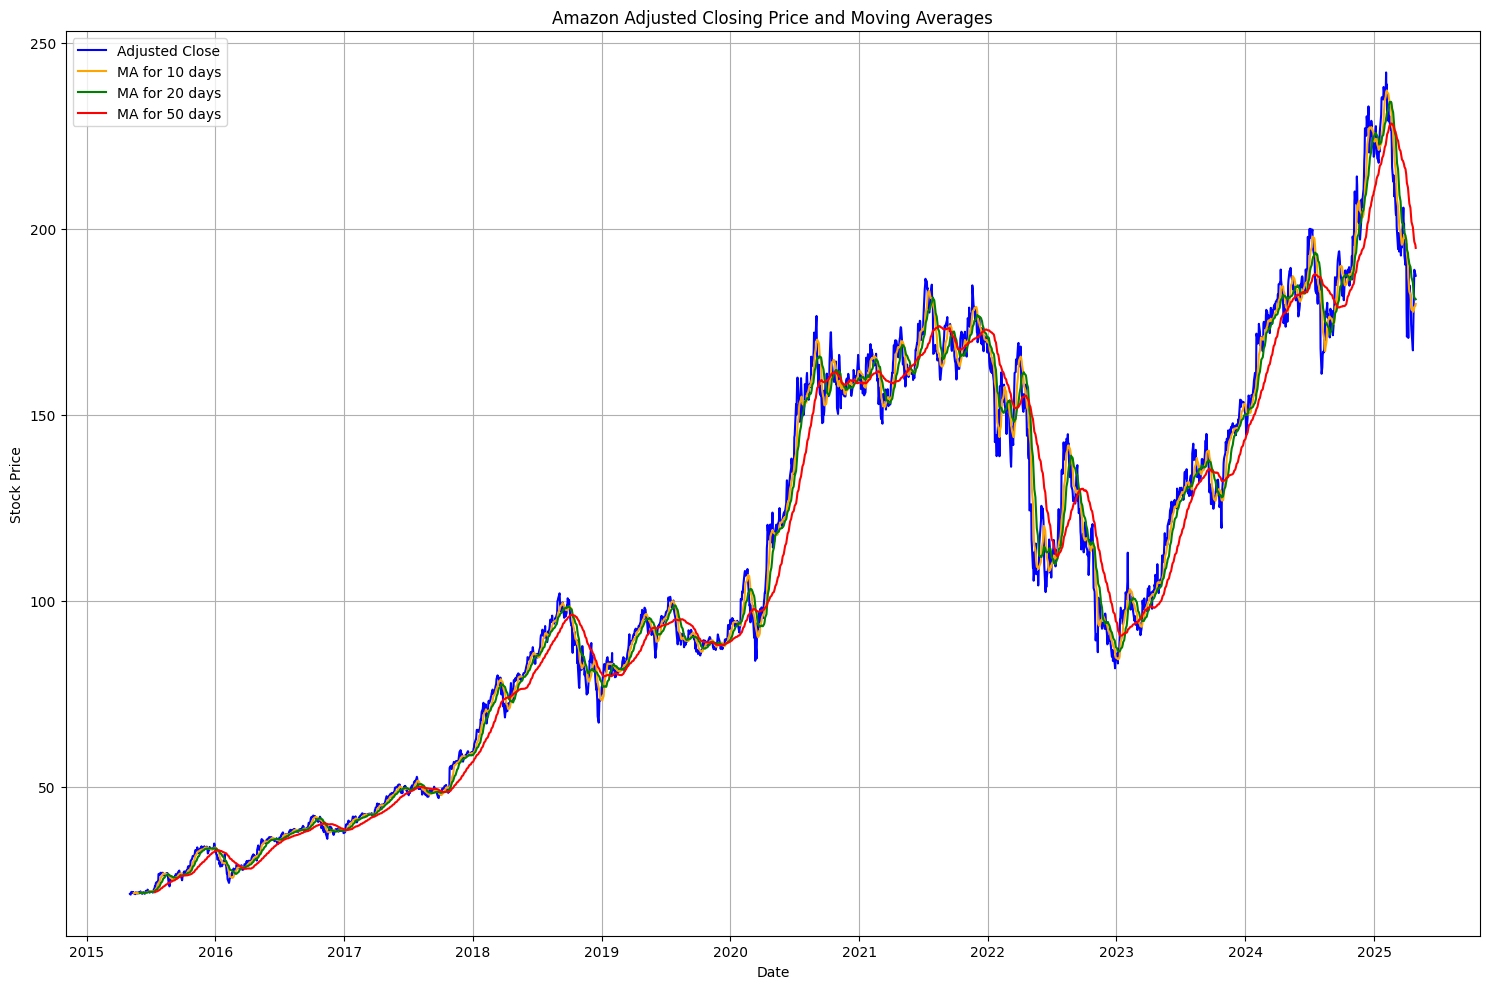

In [62]:
ma_day = [10, 20 ,50]
for ma in ma_day:
    amzn_data[f"MA for {ma} days"] = amzn_data['Adj Close'].rolling(ma).mean()

plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=0.2)

# Plotting adjusted close and moving averages
plt.plot(amzn_data['Adj Close'], label='Adjusted Close', color='blue')
plt.plot(amzn_data['MA for 10 days'], label='MA for 10 days', color='orange')
plt.plot(amzn_data['MA for 20 days'], label='MA for 20 days', color='green')
plt.plot(amzn_data['MA for 50 days'], label='MA for 50 days', color='red')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title("Amazon Adjusted Closing Price and Moving Averages")
plt.legend()
plt.tight_layout()
plt.grid()

# Show the plot
plt.show()


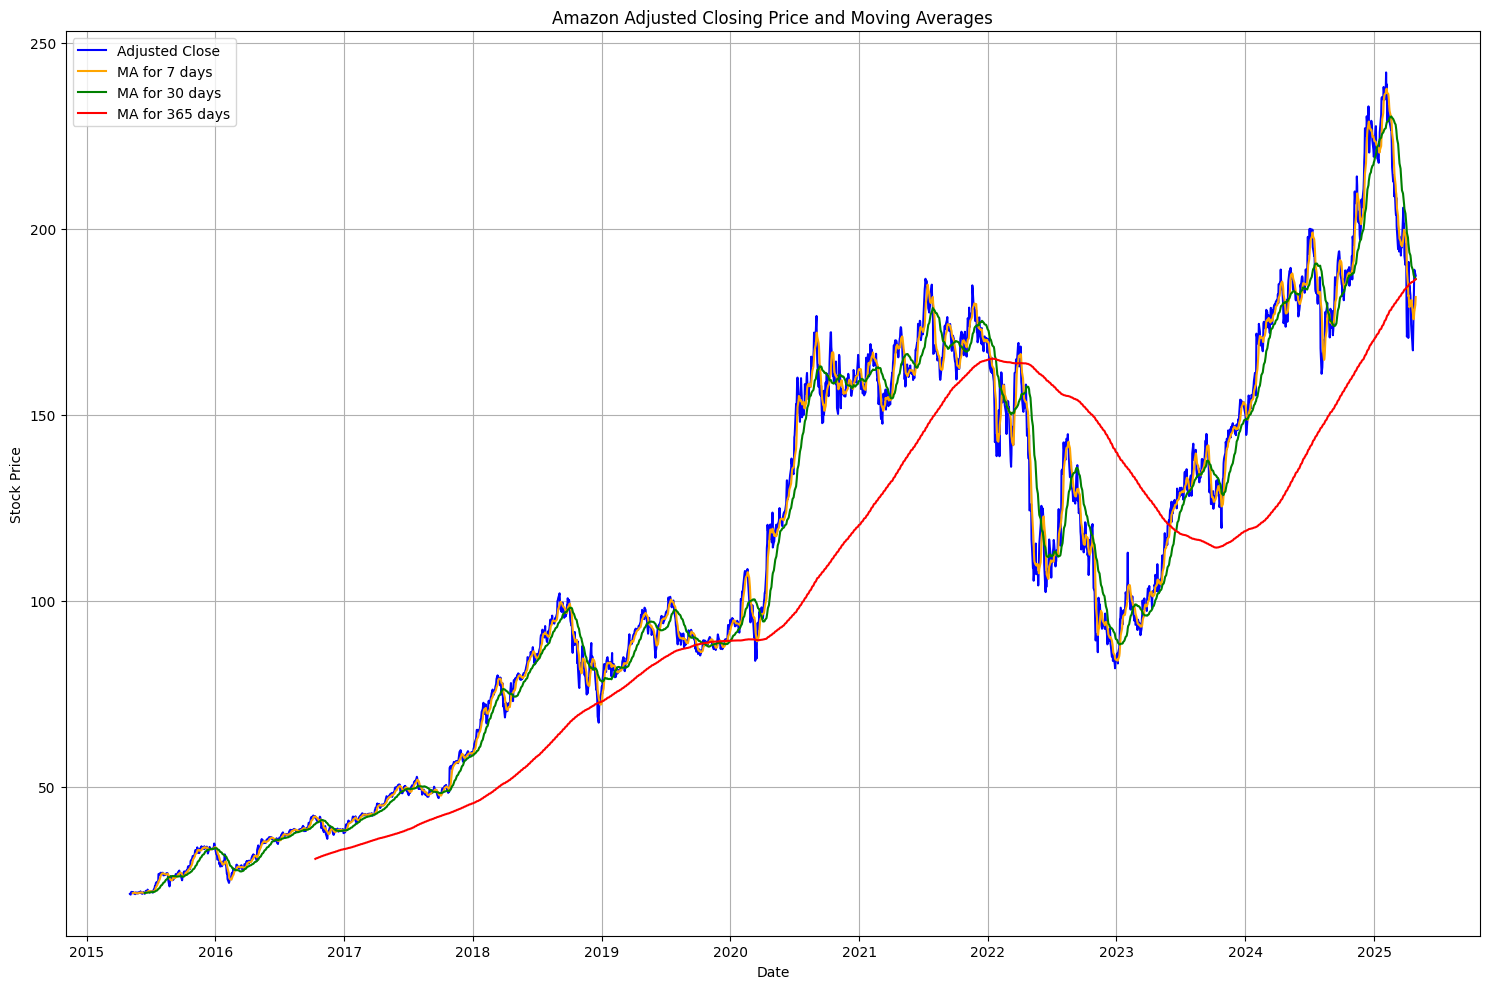

In [63]:

plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=0.2)

# Plotting adjusted close and moving averages
plt.plot(amzn_data['Adj Close'], label='Adjusted Close', color='blue')
plt.plot(amzn_data['MA_7'], label='MA for 7 days', color='orange')
plt.plot(amzn_data['MA_30'], label='MA for 30 days', color='green')
plt.plot(amzn_data['MA_365'], label='MA for 365 days', color='red')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title("Amazon Adjusted Closing Price and Moving Averages")
plt.legend()
plt.tight_layout()
plt.grid()

# Show the plot
plt.show()


2513


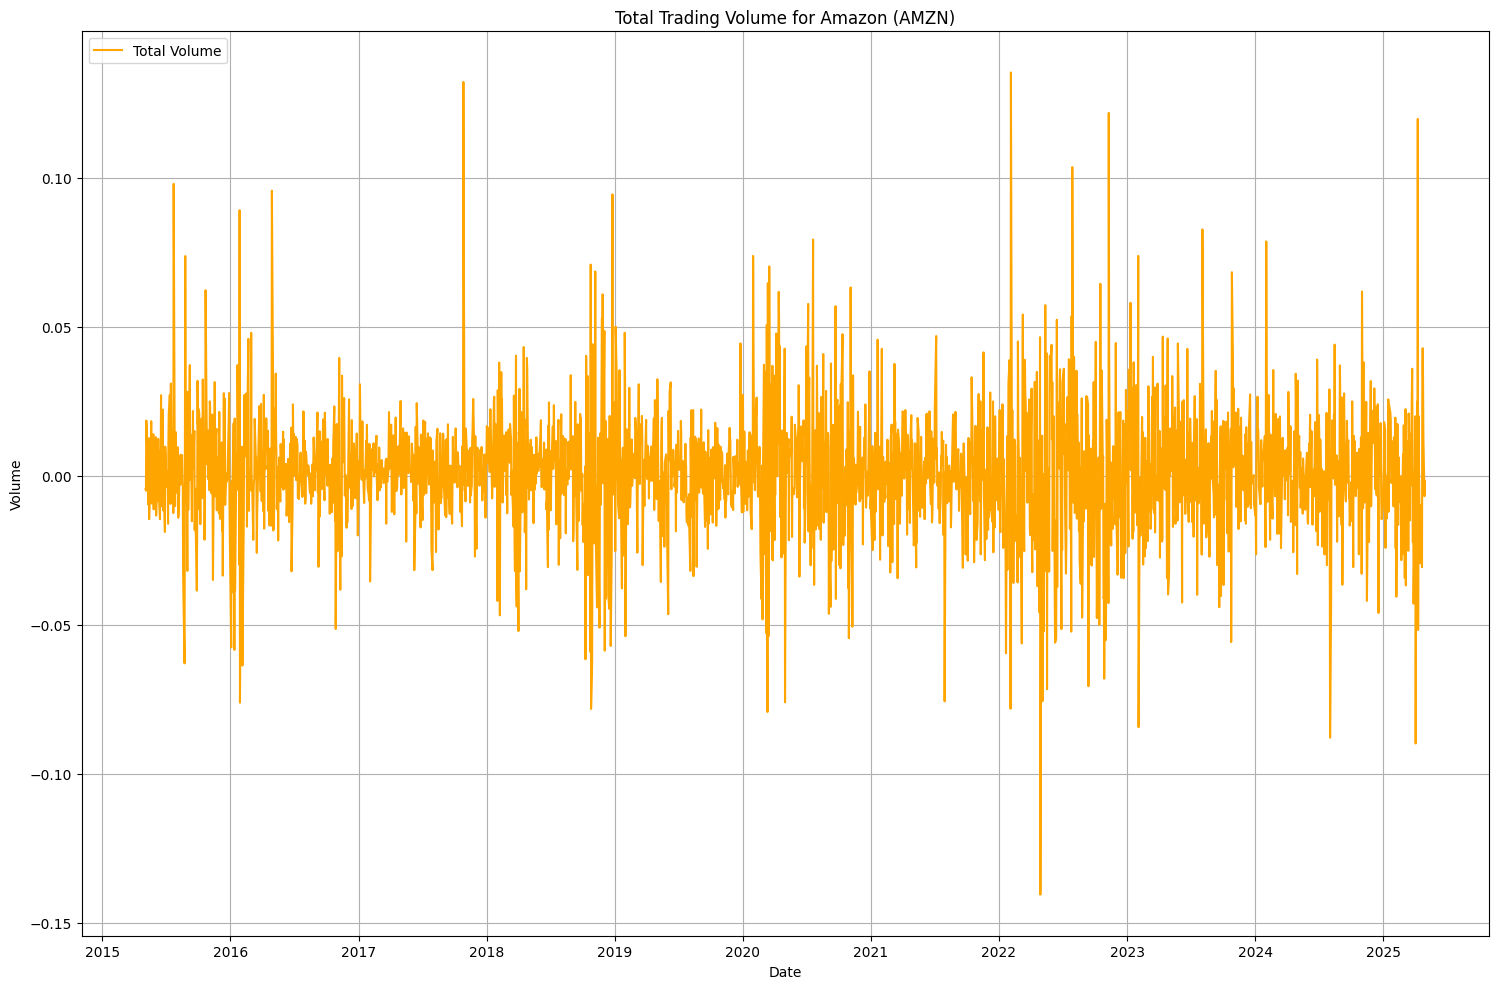

In [64]:
print(len(amzn_data))
# Now let's plot the total volume of stock being traded each day for Amazon
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

# Plotting the trading volume for AMZN
plt.plot(amzn_data['Pct_Change'], label='Total Volume', color='orange')
plt.ylabel('Volume')
plt.xlabel('Date')
plt.title("Total Trading Volume for Amazon (AMZN)")
plt.legend(loc='upper left')
plt.grid()

plt.tight_layout()
plt.show()

In [65]:
# Drop NaN values resulting from calculations

print(len(amzn_data))

# Slice original df to get most recent 3 years. This cuts off NaN values as well.
days = 1095
amzn_data = amzn_data.iloc[-(days+1):-1]

scaler = StandardScaler()
# Selecting features for training
features = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Log_Return', 'Pct_Change', 'MA_7', 'MA_30', 'MA_365', 'Volatility_7d', 'PE_Ratio']
data = amzn_data[features]

amzn_data[features] = scaler.fit_transform(amzn_data[features])

2513


<ipython-input-65-1f3d6e79f8fa>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amzn_data[features] = scaler.fit_transform(amzn_data[features])


In [66]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [67]:
X = []
y = []
print(len(amzn_data))
# print(len(amzn_data))
time_steps = 30  # Lookback period
for i in range(time_steps, len(amzn_data)):
    # the line of code below adds all the features from the lookback start to the day before the current
    X.append(amzn_data[features].iloc[i-time_steps:i].values)  # Use NumPy slicing instead of iloc
    # the line below adds only the 'closing price' feature to y on the currnet day that it's trying to predict
    y.append(amzn_data['Close'].iloc[i])

X, y = np.array(X), np.array(y)

# Train-test split for LSTM
# from sklearn.model_selection import train_test_split
# the 80% to 20% training-test split ensures that the predicted closing prices are not cheating
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)

1095
(852, 30, 13)


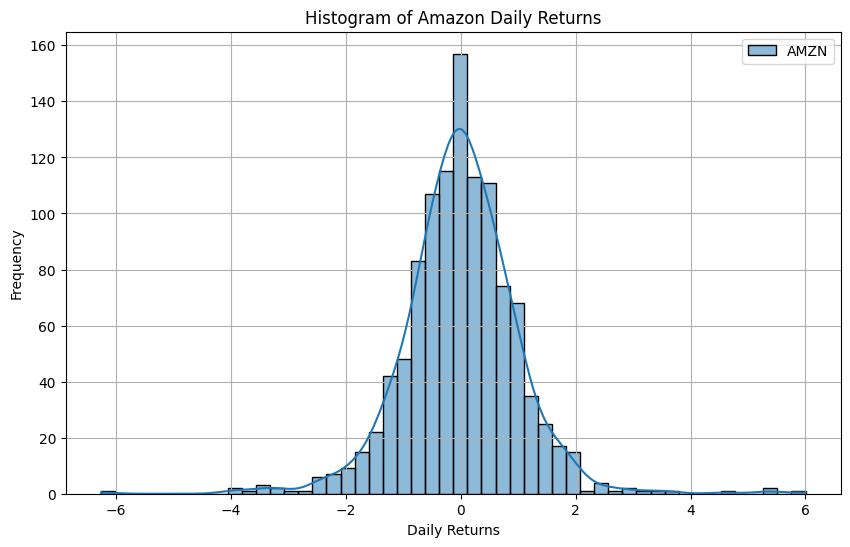

In [68]:

plt.figure(figsize=(10, 6))
sns.histplot(amzn_data['Pct_Change'].dropna(), bins=50, kde=True, color='seagreen')
plt.title('Histogram of Amazon Daily Returns')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.grid()
plt.show()


MultiIndex([(     'Adj Close', 'AMZN'),
            (         'Close', 'AMZN'),
            (          'High', 'AMZN'),
            (           'Low', 'AMZN'),
            (          'Open', 'AMZN'),
            (        'Volume', 'AMZN'),
            (      'PE_Ratio', 'AMZN'),
            (    'Log_Return', 'AMZN'),
            ( 'Volatility_7d', 'AMZN'),
            (          'MA_7', 'AMZN'),
            (         'MA_30', 'AMZN'),
            (        'MA_365', 'AMZN'),
            (    'Pct_Change', 'AMZN'),
            ('MA for 10 days',     ''),
            ('MA for 20 days',     ''),
            ('MA for 50 days',     '')],
           )
           Adj Close     Close      High       Low      Open    Volume  \
                AMZN      AMZN      AMZN      AMZN      AMZN      AMZN   
Date                                                                     
2020-12-16  0.223857  0.223857  0.177161  0.170785  0.130012  1.037832   
2020-12-17  0.216866  0.216866  0.200719  0.253357

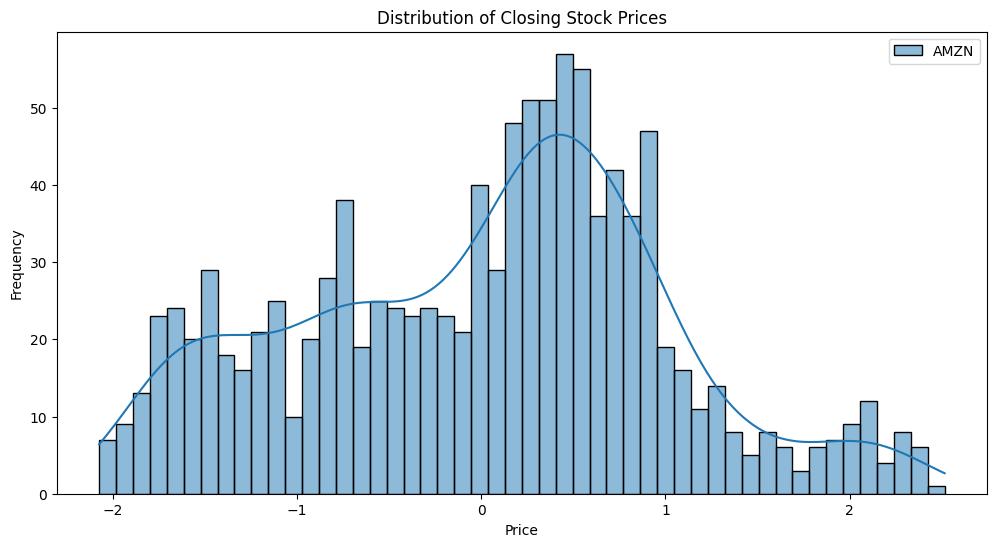

In [69]:

# Convert 'Close' column to numeric
# amzn_data['Close'] = pd.to_numeric(amzn_data['Close'], errors='coerce')
assert isinstance(amzn_data, pd.DataFrame)

print(amzn_data.columns)
# Drop rows with missing 'Close' values
# amzn_data = amzn_data.dropna(subset=['Close'])

print(amzn_data.head())
print(amzn_data.tail())
# Visualize the distribution of 'Close' prices
plt.figure(figsize=(12, 6))
sns.histplot(amzn_data['Close'], bins=50, kde=True, color='blue')
plt.title('Distribution of Closing Stock Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# # Visualize the 'Sentiment_Score'
# plt.figure(figsize=(12, 6))
# sns.histplot(amzn_data['Sentiment'], bins=50, kde=True, color='green')
# plt.title('Distribution of Sentiment Scores')
# plt.xlabel('Sentiment Score')
# plt.ylabel('Frequency')
# plt.show()


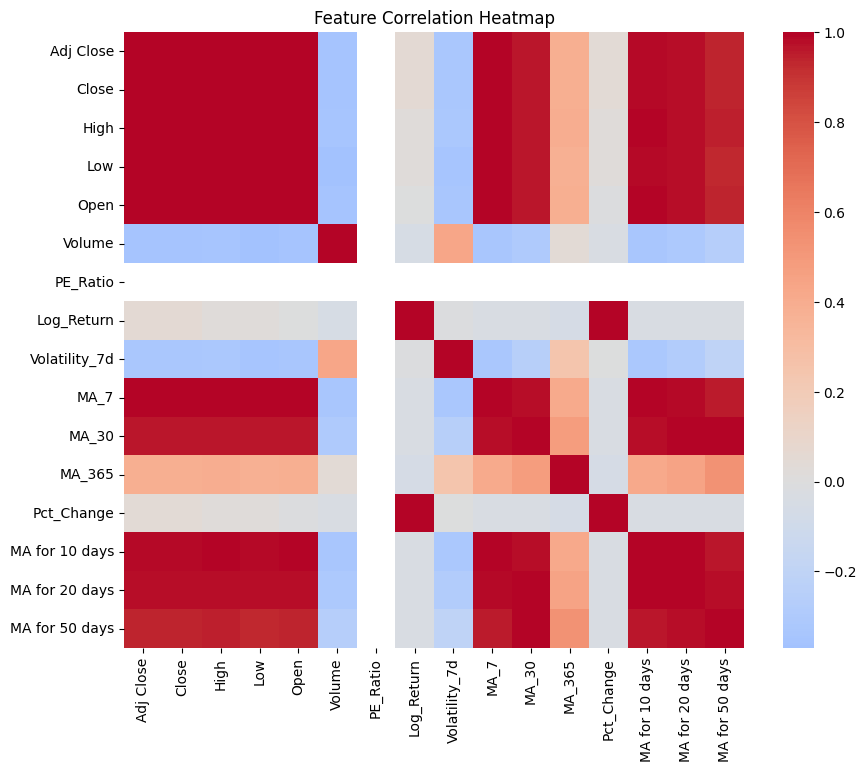

In [90]:
# Observe correlation heatmap (before PCA)

plt.figure(figsize=(10, 8))
sns.heatmap(amzn_data.corr(), annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.show()

In [91]:
# Explore data patterns/structures using PCA (dimensionality reduction)

# Perform PCA on origina data
pca = PCA(n_components=0.95)
amzn_data_pca = pca.fit_transform(amzn_data)

# Turn your MultiIndex into flat names
amzn_data.columns = [col[0] if isinstance(col, tuple) else col for col in amzn_data.columns]

# Calculate component loadings
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.n_components_)], index=amzn_data.columns)

Variance explained by components: [0.98321951]
Number of principal components: 1


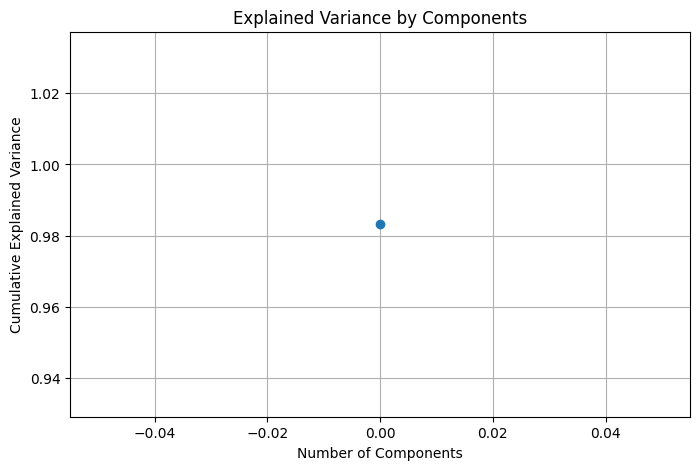

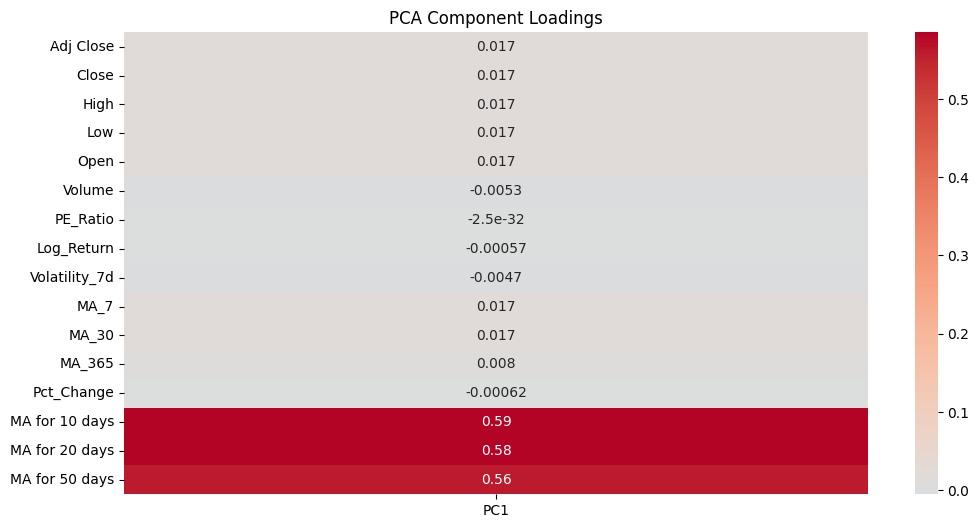

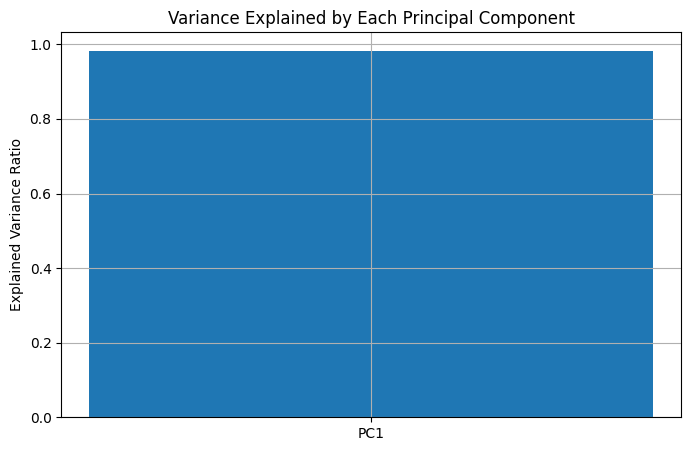

In [94]:
# Amount of variance explained by component(s)
print("Variance explained by components:", pca.explained_variance_ratio_)
# Observe: 98.3% of the variance in our data is explained by 1 principal component

# Number of principal components
print("Number of principal components:", pca.n_components_)

# Explained Variance Ratio Plot
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid(True)
plt.show()

# Plot a heatmap of the loadings
plt.figure(figsize=(12, 6))
sns.heatmap(loadings, cmap='coolwarm', center=0, annot=True)
plt.title('PCA Component Loadings')
plt.show()

# Bar Plot of Individual Explained Variance per Component
plt.figure(figsize=(8, 5))
plt.bar(x=[f'PC{i+1}' for i in range(pca.n_components_)], height=pca.explained_variance_ratio_)
plt.ylabel('Explained Variance Ratio')
plt.title('Variance Explained by Each Principal Component')
plt.grid(True)
plt.show()

In [30]:
# Tuning the LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dropout(0.23),
    Dense(50),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# model.fit(X_train, y_train, batch_size=1, epochs=1)
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))




/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step - loss: 0.5553 - val_loss: 0.0712
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.1656 - val_loss: 0.0582
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0924 - val_loss: 0.0897
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0891 - val_loss: 0.0345
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0709 - val_loss: 0.0291
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0589 - val_loss: 0.0249
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0440 - val_loss: 0.0295
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0468 - val_loss: 0.0196
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0376 - val_loss: 0.0191
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0364 - val_loss: 0.0173
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0379 - val_loss: 0.0139
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0403 - val_loss: 0.0134

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 284ms/step


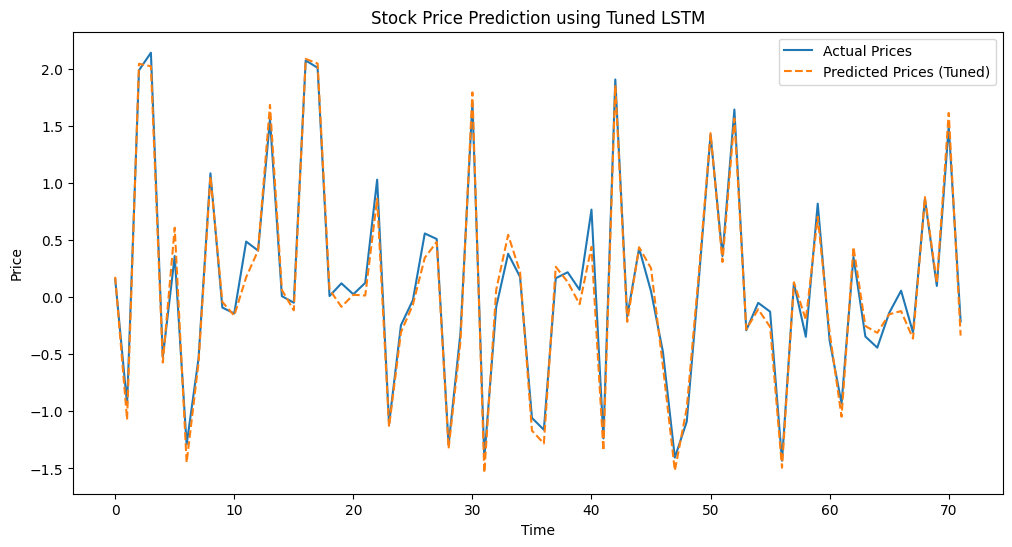

In [31]:
# use the trained LSTM to predict the closing prices for the p
lstm_predictions_model = model.predict(X_test)

# Plot the results for the tuned LSTM model
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Prices")
plt.plot(lstm_predictions_model, label="Predicted Prices (Tuned)", linestyle='--')
plt.title('Stock Price Prediction using Tuned LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()



In [32]:
# Calculate metrics
mse = mean_squared_error(y_test, lstm_predictions_model)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, lstm_predictions_model)
r2 = r2_score(y_test, lstm_predictions_model)

# Output the results
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R²):", r2)

Mean Squared Error (MSE): 0.012883634810130965
Root Mean Squared Error (RMSE): 0.11350610032122047
Mean Absolute Error (MAE): 0.09042244915061162
R-squared (R²): 0.9838384540372854


In [33]:
# Tuning the LSTM model
model2 = Sequential([
    LSTM(64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    Dense(50, activation='relu'),
    Dense(1)
])

# Compile the model
model2.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# model.fit(X_train, y_train, batch_size=1, epochs=1)
model2.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - loss: 0.8885 - val_loss: 0.4142
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.3647 - val_loss: 0.1057
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1132 - val_loss: 0.0667
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1260 - val_loss: 0.0536
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0984 - val_loss: 0.0294
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0798 - val_loss: 0.0369
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0556 - val_loss: 0.0275
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0513 - val_loss: 0.0173
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0545 - val_loss: 0.0177
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0478 - val_loss: 0.0181
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0490 - val_loss: 0.0185
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0347 - val_loss: 0.0162
Epoch 13/50

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


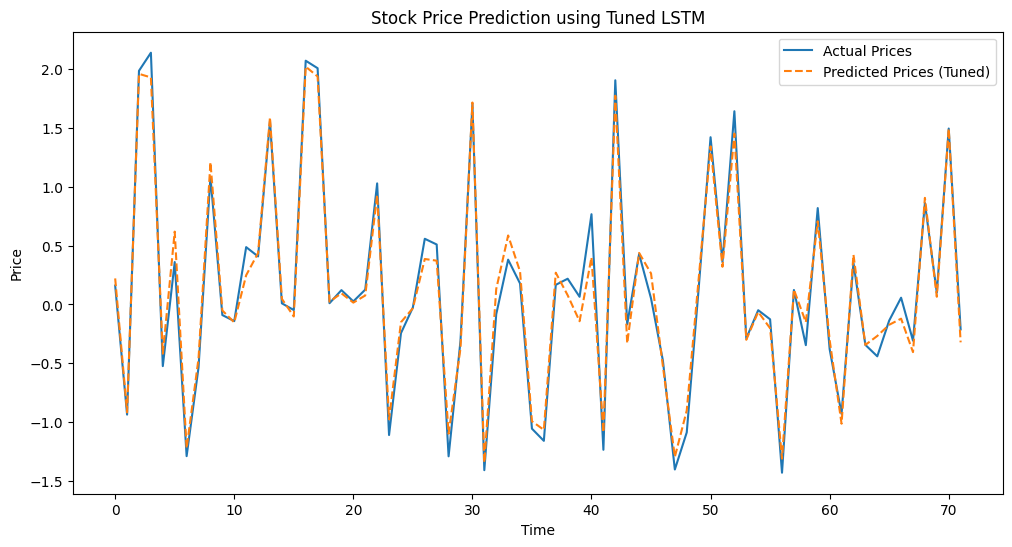

In [34]:
# use the trained LSTM to predict the closing prices for the p
lstm_predictions_model2 = model2.predict(X_test)

# lstm_predictions_model2 = lstm_predictions_model2[:, -1, 0]
# Plot the results for the tuned LSTM model
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Prices")
plt.plot(lstm_predictions_model2, label="Predicted Prices (Tuned)", linestyle='--')
plt.title('Stock Price Prediction using Tuned LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [35]:
# Calculate metrics
mse = mean_squared_error(y_test, lstm_predictions_model2)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, lstm_predictions_model2)
r2 = r2_score(y_test, lstm_predictions_model2)

# Output the results
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R²):", r2)

Mean Squared Error (MSE): 0.014812448496286977
Root Mean Squared Error (RMSE): 0.1217064028565752
Mean Absolute Error (MAE): 0.09612622454875314
R-squared (R²): 0.9814189030719157


In [36]:
# Tuning the LSTM model
model3 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(64, return_sequences=True),
    Dropout(0.23),
    LSTM(80, return_sequences=False),
    Dropout(0.23),
    Dense(50),
    Dense(1)
])

# Compile the model
model3.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# model.fit(X_train, y_train, batch_size=1, epochs=1)
model3.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 329ms/step - loss: 0.6853 - val_loss: 0.1443
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.1999 - val_loss: 0.1418
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.1477 - val_loss: 0.0486
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.1013 - val_loss: 0.0416
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0863 - val_loss: 0.0934
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0947 - val_loss: 0.0305
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0890 - val_loss: 0.0282
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0718 - val_loss: 0.0402
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0646 - val_loss: 0.0285
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0622 - val_loss: 0.0237
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0544 - val_loss: 0.0312
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0537 - val_loss: 0.0237
Epoch 13/50

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step


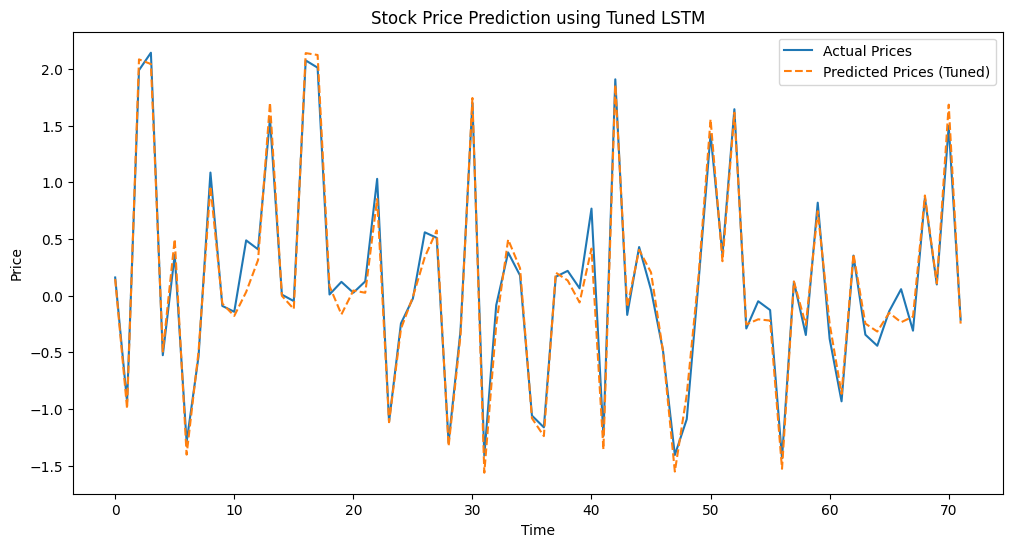

In [37]:
# use the trained LSTM to predict the closing prices for the p
lstm_predictions_model3 = model3.predict(X_test)

# lstm_predictions_model3 = lstm_predictions_model3[:, -1, 0]
# Plot the results for the tuned LSTM model
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Prices")
plt.plot(lstm_predictions_model3, label="Predicted Prices (Tuned)", linestyle='--')
plt.title('Stock Price Prediction using Tuned LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [38]:
# Calculate metrics
mse = mean_squared_error(y_test, lstm_predictions_model3)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, lstm_predictions_model3)
r2 = r2_score(y_test, lstm_predictions_model3)

# Output the results
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R²):", r2)

Mean Squared Error (MSE): 0.015624045958692497
Root Mean Squared Error (RMSE): 0.12499618377651574
Mean Absolute Error (MAE): 0.0938771768448617
R-squared (R²): 0.9804008154060363


In [39]:
#NEURAL NETWORKS
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

X_train = X_train.reshape(X_train.shape[0], -1)  # Flatten to (num_samples, 390)
X_test = X_test.reshape(X_test.shape[0], -1)     # Flatten to (num_samples, 390)

print(X_train.shape)
print(X_test.shape)
# Creating the Neural Network Model
NNmodel = Sequential()
# Input layer and Hidden layer
NNmodel.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='relu'))  # Activation function can be ReLU
# input layer takes into account the features of each sample during each of the time_steps
# Output layer, with 1 neuron for regression
NNmodel.add(Dense(1))  # No activation function for regression output
# Compile/build the model
NNmodel.compile(loss='mean_squared_error', optimizer='adam')

NNmodel.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))


(285, 390)
(72, 390)
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - loss: 0.5457 - val_loss: 0.4332
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.2229 - val_loss: 0.4203
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1783 - val_loss: 0.2697
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1386 - val_loss: 0.2849
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1256 - val_loss: 0.2012
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0721 - val_loss: 0.1937
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0625 - val_loss: 0.1709
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0499 - val_loss: 0.1606
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0391 - val_loss: 0.1567
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0448 - val_loss: 0.1499
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0297 - val_loss: 0.1395
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0218 - val_loss: 0.1381
Epoch 13/50

In [40]:
NN_predictions_model = NNmodel.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


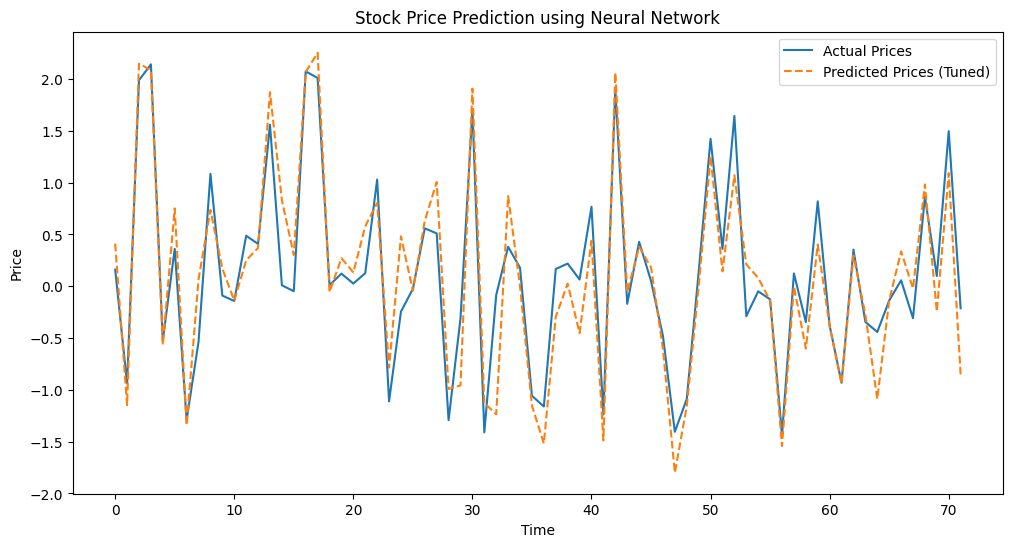

In [41]:

# Plot the results for the tuned NN model
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Prices")
plt.plot(NN_predictions_model, label="Predicted Prices (Tuned)", linestyle='--')
plt.title('Stock Price Prediction using Neural Network')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [42]:
# Calculate metrics
mse = mean_squared_error(y_test, NN_predictions_model)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, NN_predictions_model)
r2 = r2_score(y_test, NN_predictions_model)

# Output the results
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R²):", r2)

Mean Squared Error (MSE): 0.11909111534745422
Root Mean Squared Error (RMSE): 0.34509580604153134
Mean Absolute Error (MAE): 0.264304121257543
R-squared (R²): 0.8506091981957339


In [43]:
# Creating the Neural Network Model
NNmodel2 = Sequential()
# Input layer and Hidden layer
# print(X.shape[2])
NNmodel2.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.1)))  # Activation function can be ReLU
# input layer takes into account the features of each sample during each of the time_steps
# Output layer, with 1 neuron for regression
NNmodel2.add(Dense(1))  # No activation function for regression output
# Compile/build the model
NNmodel2.compile(loss='mean_squared_error', optimizer='adam')

NNmodel2.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 6.3650 - val_loss: 5.6063
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 5.5246 - val_loss: 5.0985
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 5.0098 - val_loss: 4.7125
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.6134 - val_loss: 4.3192
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.2041 - val_loss: 3.9433
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3.8563 - val_loss: 3.6086
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.5218 - val_loss: 3.3026
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.2117 - val_loss: 3.0046
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.9176 - val_loss: 2.7345
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.6444 - val_loss: 2.4837
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.4027 - val_loss: 2.2543
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.1789 - val_loss: 2.0457
Epoch 13/50


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


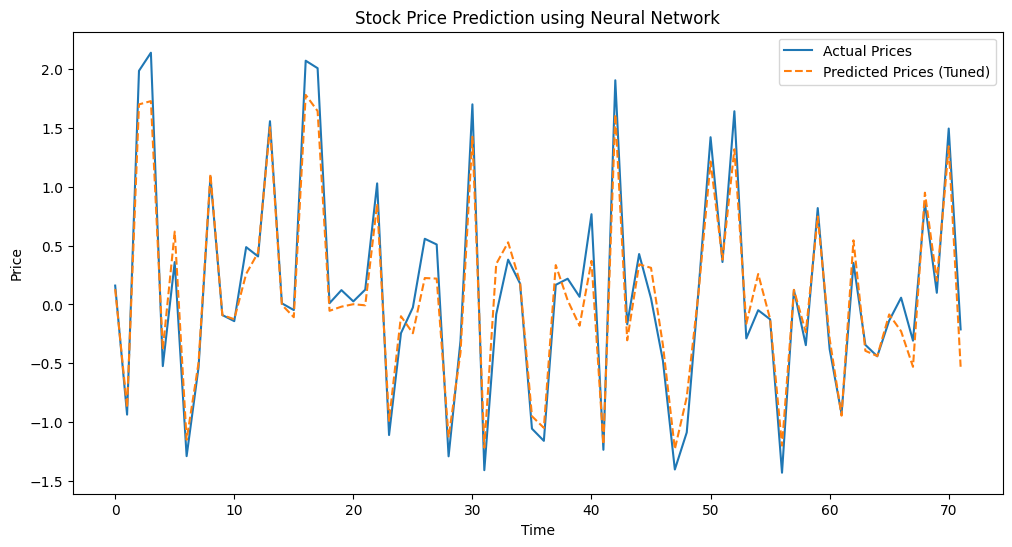

In [44]:
NN_predictions_model2 = NNmodel2.predict(X_test)

# Plot the results for the tuned NN model
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Prices")
plt.plot(NN_predictions_model2, label="Predicted Prices (Tuned)", linestyle='--')
plt.title('Stock Price Prediction using Neural Network')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [45]:
# Calculate metrics
mse = mean_squared_error(y_test, NN_predictions_model2)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, NN_predictions_model2)
r2 = r2_score(y_test, NN_predictions_model2)

# Output the results
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R²):", r2)

Mean Squared Error (MSE): 0.036421034702877414
Root Mean Squared Error (RMSE): 0.19084295822187786
Mean Absolute Error (MAE): 0.1532926361987649
R-squared (R²): 0.9543125651235227


In [46]:
NNmodel3 = Sequential()
# Input layer and Hidden layer
NNmodel3.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.1)))  # Activation function can be ReLU
# input layer takes into account the features of each sample during each of the time_steps
# Output layer, with 1 neuron for regression
NNmodel3.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.1)))

NNmodel3.add(Dense(1))  # No activation function for regression output
# Compile/build the model
NNmodel3.compile(loss='mean_squared_error', optimizer='adam')

NNmodel3.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 9.2631 - val_loss: 8.4518
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 8.3603 - val_loss: 7.8442
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 7.7338 - val_loss: 7.3450
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 7.2456 - val_loss: 6.8557
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 6.7510 - val_loss: 6.3709
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 6.2842 - val_loss: 5.9354
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 5.8432 - val_loss: 5.5232
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 5.4318 - val_loss: 5.1307
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 5.0459 - val_loss: 4.7633
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 4.6873 - val_loss: 4.4235
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.3555 - val_loss: 4.1077
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.0432 - val_loss: 3.8158
Epoch 13/50


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


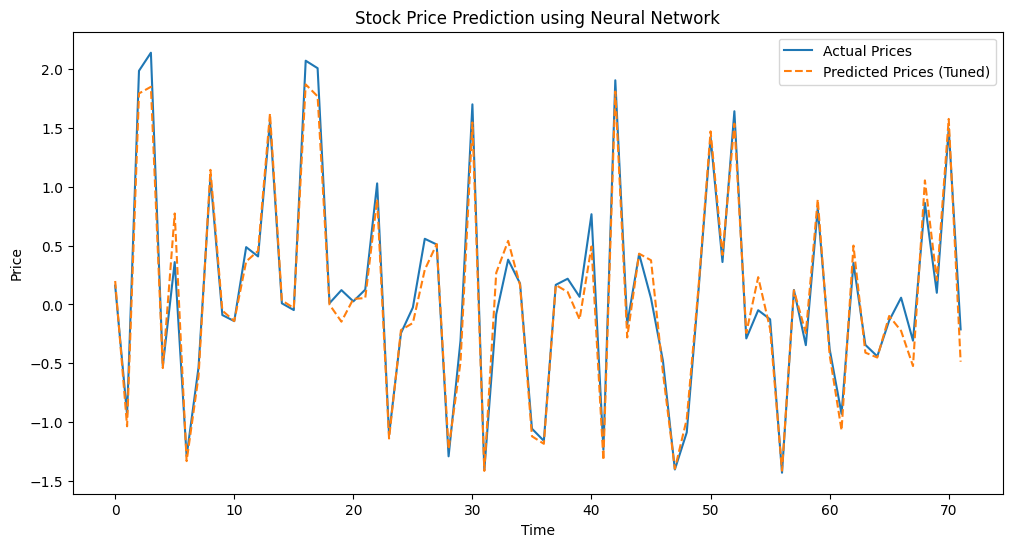

In [47]:
NN_predictions_model3 = NNmodel3.predict(X_test)

# Plot the results for the tuned NN model
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Prices")
plt.plot(NN_predictions_model3, label="Predicted Prices (Tuned)", linestyle='--')
plt.title('Stock Price Prediction using Neural Network')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [48]:
# Calculate metrics
mse = mean_squared_error(y_test, NN_predictions_model3)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, NN_predictions_model3)
r2 = r2_score(y_test, NN_predictions_model3)

# Output the results
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R²):", r2)

Mean Squared Error (MSE): 0.021508631872964548
Root Mean Squared Error (RMSE): 0.14665821447489585
Mean Absolute Error (MAE): 0.10898183599112708
R-squared (R²): 0.9730190472073393


In [49]:
NNmodel4 = Sequential()
# Input layer and Hidden layer
NNmodel4.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.1)))  # Activation function can be ReLU
# input layer takes into account the features of each sample during each of the time_steps
# Output layer, with 1 neuron for regression
NNmodel4.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.1)))
NNmodel4.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='relu', kernel_regularizer=l2(0.1)))
NNmodel4.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='sigmoid', kernel_regularizer=l2(0.1)))
NNmodel4.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.1)))

NNmodel4.add(Dense(1))  # No activation function for regression output
# Compile/build the model
NNmodel4.compile(loss='mean_squared_error', optimizer='adam')

NNmodel4.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - loss: 18.3572 - val_loss: 17.2521
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 16.9904 - val_loss: 16.1445
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 15.9303 - val_loss: 15.0927
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 14.8730 - val_loss: 14.1093
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 13.9058 - val_loss: 13.1940
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 13.0044 - val_loss: 12.3450
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 12.1619 - val_loss: 11.5587
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 11.4086 - val_loss: 10.8318
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 10.6987 - val_loss: 10.1623
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 10.0050 - val_loss: 9.5415
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 9.3941 - val_loss: 8.9678
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 8.8620 - val_loss:

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


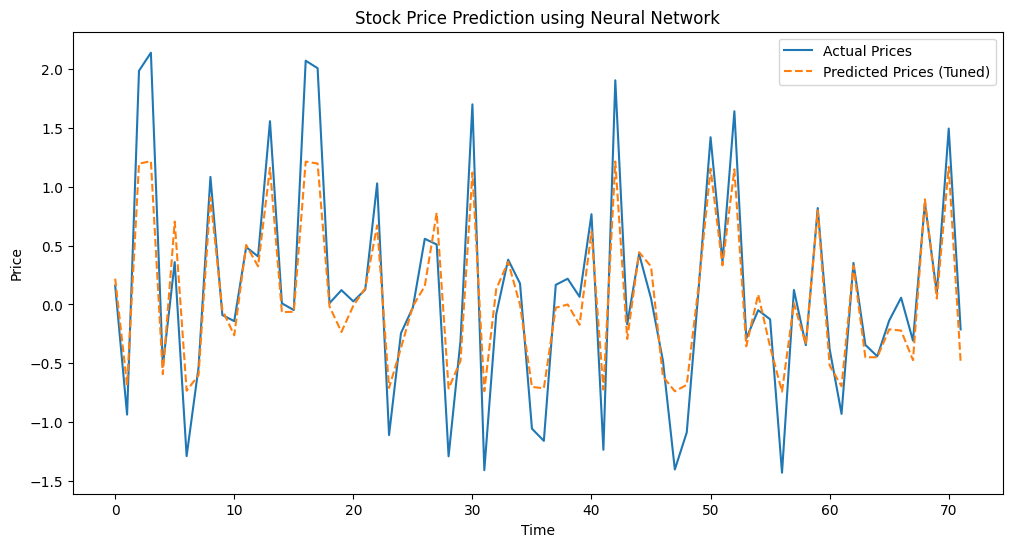

In [50]:
NN_predictions_model4 = NNmodel4.predict(X_test)

# Plot the results for the tuned NN model
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Prices")
plt.plot(NN_predictions_model4, label="Predicted Prices (Tuned)", linestyle='--')
plt.title('Stock Price Prediction using Neural Network')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [51]:
# Calculate metrics
mse = mean_squared_error(y_test, NN_predictions_model4)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, NN_predictions_model4)
r2 = r2_score(y_test, NN_predictions_model4)

# Output the results
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R²):", r2)

Mean Squared Error (MSE): 0.1208827656540133
Root Mean Squared Error (RMSE): 0.34768198925744387
Mean Absolute Error (MAE): 0.2539842550465387
R-squared (R²): 0.8483617083215411
